# Use Stan Model for Bayes Hierarchical RL
- Estimate learning rate (i.e. alpha) for each subject using this model

In [103]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
# import stan
import cmdstanpy
#import pymc3 as pm
import arviz as az
# import learning package
#import DMpy

In [104]:
# read scr file
scr = pd.read_csv('firstSCRpart.csv')
scr['sub'].unique()

array([ 189,   86,  205,   71,   87,  204,   85,   24,  101,  100,  132,
        185,  167,   43,   62,  105,   73,   82,   30,  160,  196,  146,
       1223,  106,    8,   94,  112,  169, 1222,   55,  170,  131,   47,
        177,   89,  130,  172,  200,  173,   26,   59,    1,   72, 1232,
        166,   32,   11,  104,   16, 1205,  186,   56,   53,  150,   65,
        154,  193,  165,    4,  103,   95,  168,   20,  102,   75,   48,
         27,    5,  136,  182,  202,  114,  121,   81,  203,  108,   80,
        122,   66,   38,  184,  171,  183,   13,   22,  179,  592,  153,
        144,  178,   63,  124,   21,   19,   10,  158,   83,  113,  107,
        126,  152])

In [105]:
# grab just two subjects for now
scrTwo = scr[(scr['sub']==63) | (scr['sub']==113) | (scr['sub']==107) | (scr['sub']==80) |(scr['sub']==65) 
             | (scr['sub']==171) |(scr['sub']==10)]
scrTwo['sub'].unique()

array([ 65,  80, 171,  63,  10, 113, 107])

In [106]:
# organize data accordingly
# first, grab just the relevant variables (subject, trial, stimuli, shock)
# we need to generate a new variable shock (1=yes, 0=no)
# we also need a new variable stim (1=CS+, 2=CS-)
scrVec = scrTwo['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scrTwo['Condition'].values):
    #print(i)
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    else:
        shockVec[i] = 0
        if cond=='CSminus1':
            stimVec[i] = 2
        else:
            stimVec[i] = 1
print(shockVec.shape)
print(stimVec.shape)
nTrials = 30 #len(scrTwo['Event.Nr']) # grab number of trials

(210,)
(210,)
(210,)


In [107]:
Tsubj = [30,30, 30, 30,30,30,30] # set trials per subject
# create matrix for shocks (trials X Subject), scr (trials X subject) and stimulus (trials X subject)
stim = np.reshape(stimVec, (7,30)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (7,30)).T 
scrMat = np.reshape(scrVec, (7,30)).T
scrVec

array([0.6964, 0.2629, 0.1027, 0.0235, 0.0536, 0.191 , 0.1527, 0.0256,
       0.0136, 0.0588, 0.0372, 0.036 , 0.0295, 0.    , 0.0333, 0.027 ,
       0.023 , 0.1184, 0.0131, 0.    , 0.    , 0.    , 0.0106, 0.    ,
       0.0241, 0.    , 0.    , 0.    , 0.0111, 0.0148, 2.8673, 1.9791,
       2.3691, 1.6095, 0.861 , 1.6297, 1.1378, 0.1635, 1.9387, 0.8517,
       0.0694, 0.3937, 1.9691, 0.6972, 0.2927, 0.0566, 0.0226, 0.335 ,
       0.0479, 0.1246, 1.3782, 0.    , 1.1599, 0.    , 0.0283, 0.    ,
       0.7198, 0.089 , 0.0887, 0.5235, 2.459 , 1.6494, 2.3828, 2.3473,
       0.2857, 0.752 , 1.3659, 1.4341, 1.3047, 0.1117, 0.1952, 0.9142,
       0.    , 0.0885, 0.046 , 0.0893, 0.53  , 0.9667, 0.0887, 0.15  ,
       0.0386, 0.1453, 0.    , 0.2099, 0.    , 0.    , 0.0674, 0.1098,
       0.116 , 0.    , 1.5866, 0.0334, 0.1839, 0.3563, 0.0198, 1.0713,
       1.2482, 0.3818, 1.2524, 0.    , 0.6836, 0.4828, 0.1264, 1.1694,
       0.8891, 0.6399, 0.1206, 0.534 , 0.0624, 0.    , 1.0958, 0.    ,
      

In [108]:
data =  {'N': 7, 'T': 30, 'Tsubj': Tsubj, 'scr': scrMat, 'lambda':shock,
'stim': stim}
rw_bayes = cmdstanpy.CmdStanModel(stan_file='scr_model.stan')
#rw_bayes = cmdstanpy.CmdStanModel(stan_file='bayes_stan_rw.stan')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/Documents/amg_hippo_fc/scr_model


In [109]:
# Train the model and generate samples
seed = 1332 # set random seed
fit_simple_model = rw_bayes.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seed
  #inits = 0.2,
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


In [110]:
fit_simple_model.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,180.000,0.1700,5.300,170.000,180.0000,190.00,1000.0,45.0,1.0
mu_p[1],-0.850,0.0050,0.230,-1.200,-0.8400,-0.50,2047.0,89.0,1.0
mu_p[2],-0.013,0.0016,0.055,-0.096,-0.0083,0.06,1207.0,53.0,1.0
mu_p[3],0.910,0.0130,0.440,0.170,0.9200,1.60,1154.0,50.0,1.0
mu_p[4],-1.100,0.0160,0.510,-1.900,-1.2000,-0.21,1014.0,44.0,1.0
...,...,...,...,...,...,...,...,...,...
log_lik[3],-30.000,0.0240,1.200,-32.000,-30.0000,-29.00,2593.0,113.0,1.0
log_lik[4],-18.000,0.0220,1.100,-20.000,-18.0000,-17.00,2570.0,112.0,1.0
log_lik[5],56.000,0.0300,1.300,53.000,56.0000,57.00,2027.0,88.0,1.0


In [111]:
model = az.from_cmdstanpy(fit_simple_model)
az.summary(model, var_names=['A', 'mu_p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.211,0.091,0.042,0.367,0.002,0.001,3281.0,1907.0,1.0
A[1],0.213,0.072,0.080,0.347,0.001,0.001,5554.0,3212.0,1.0
A[2],0.218,0.066,0.100,0.347,0.001,0.001,4261.0,2957.0,1.0
A[3],0.181,0.066,0.056,0.298,0.001,0.001,3041.0,2362.0,1.0
A[4],0.196,0.097,0.000,0.337,0.002,0.001,2474.0,1468.0,1.0
A[5],0.204,0.055,0.091,0.301,0.001,0.001,4188.0,2912.0,1.0
A[6],0.206,0.092,0.006,0.354,0.002,0.001,2776.0,1600.0,1.0
mu_p[0],-0.846,0.226,-1.310,-0.447,0.005,0.004,2439.0,1890.0,1.0
mu_p[1],-0.013,0.055,-0.114,0.085,0.002,0.001,1914.0,1312.0,1.0
mu_p[2],0.906,0.438,0.044,1.681,0.013,0.009,1174.0,1661.0,1.0


array([[<AxesSubplot:title={'center':'A\n0'}>,
        <AxesSubplot:title={'center':'A\n1'}>,
        <AxesSubplot:title={'center':'A\n2'}>],
       [<AxesSubplot:title={'center':'A\n3'}>,
        <AxesSubplot:title={'center':'A\n4'}>,
        <AxesSubplot:title={'center':'A\n5'}>],
       [<AxesSubplot:title={'center':'A\n6'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

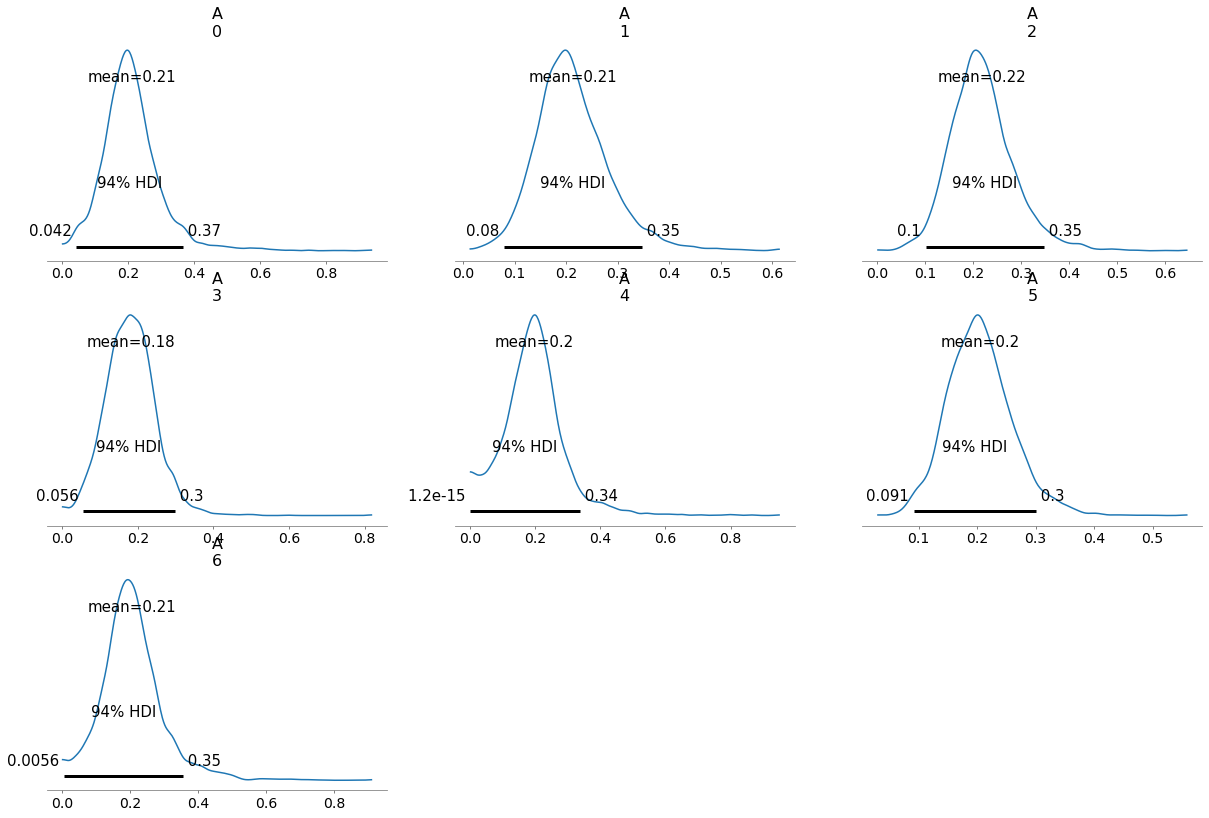

In [112]:
az.plot_posterior(model, var_names=['A'])

Uncertainty is very big. 